In [1]:
# Load packages

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
import os

Unzipped folder already exists. Skipping extraction.


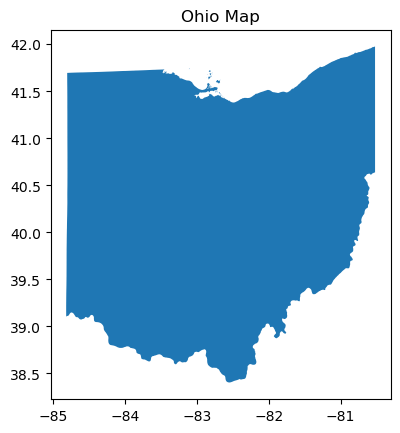

In [2]:
# Get Ohio boundary

# Unzip Ohio precint shapefile data
path = "project_data/Ohio_Boundary"

if not os.path.exists(path):
    with zipfile.ZipFile("project_data/Ohio_Boundary.zip", "r") as zip_ref:
        zip_ref.extractall("project_data/Ohio_Boundary")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")

# Get data
gdf_ohio = gpd.read_file("project_data/Ohio_Boundary/Ohio_Boundary.shp")

# Reprojecting to epsg:4326
gdf_ohio_proj = gdf_ohio.to_crs(epsg=4326)

# Map
gdf_ohio_proj.plot()

plt.title("Ohio Map")
plt.show()

In [3]:
# Unzip Ohio congressional district shapefile data

path = "./data2/2024_us_cd119"

if not os.path.exists(path):
    with zipfile.ZipFile("./data2/cb_2024_us_cd119_5m.zip", "r") as zip_ref:
        zip_ref.extractall("./data2/2024_us_cd119")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")

Unzipped folder already exists. Skipping extraction.


In [4]:
# Get congressional district spatial data
gdf_cd = gpd.read_file("./data2/2024_us_cd119/cb_2024_us_cd119_5m.shp")

#gdf_cd.head()

# Filter to Ohio only
gdf_cd = gdf_cd[gdf_cd['STATEFP'] == '39']

# Limit to specified columns
columns_gdf_cd = ['CD119FP', 'GEOID', 'geometry']
gdf_cd = gdf_cd[columns_gdf_cd]

# Preview
gdf_cd.head()

,CD119FP,GEOID,geometry
34,06,3906,"POLYGON ((-81.84486 39.45022, -81.82576 39.449..."
137,13,3913,"POLYGON ((-81.68780 41.02566, -81.68762 41.062..."
138,02,3902,"POLYGON ((-84.31524 39.05734, -84.31481 39.061..."
200,09,3909,"MULTIPOLYGON (((-82.73280 41.60432, -82.72107 ..."
212,15,3915,"POLYGON ((-84.43257 40.19704, -84.43396 40.270..."


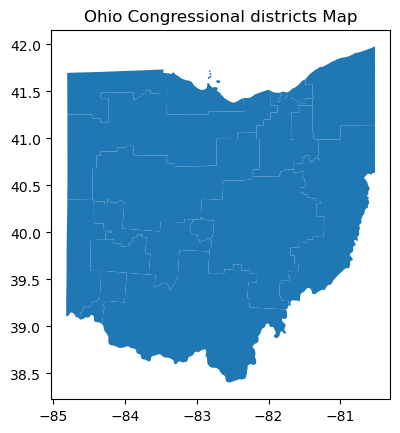

In [ ]:
# Reprojecting to epsg:4326

gdf_cd_proj = gdf_cd.to_crs(epsg=4326)

# Map reprojected data
gdf_cd_proj.plot()
plt.title("Ohio Congressional districts Map")
plt.show()

In [ ]:
# Get land coverage data

# Unzip Ohio area land coverage data
path = "data2/Land_Coverage"

if not os.path.exists(path):
    with zipfile.ZipFile("data2/LandCoverage2023.zip", "r") as zip_ref:
        zip_ref.extractall("data2/Land_Coverage")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")


Unzipped successfully.


In [9]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from shapely.geometry import mapping

# Get land coverage data
tif_path = "./data2/Land_Coverage/Annual_NLCD_LndCov_2023_CU_C1V0_mbz2nnWtbK9pyVOVuoBh.tiff"

# Reproject land coverage data onto ESPG: 4326
dst_crs = 'EPSG:4326'
reprojected_tif_path = "./data2/land_coverage_reprojected.tif"

with rasterio.open(tif_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

# Create new reprojected .tif file called: land_coverage_reprojected.tif
    with rasterio.open(reprojected_tif_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )


In [10]:

# Read Ohio boundary shapefile
shp_path = "project_data/Ohio_Boundary/Ohio_Boundary.shp"
ohio = gpd.read_file(shp_path)

# Reproject Ohio to espg=4326
ohio = ohio.to_crs(dst_crs)
ohio_geom = [mapping(geom) for geom in ohio.geometry]

# Clip reprojected .tif path with shape file of Ohio
with rasterio.open(reprojected_tif_path) as src:
    out_image, out_transform = mask(
        dataset=src,
        shapes=ohio_geom,
        crop=True,
        all_touched=True
    )

    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Create new clipped .tif file called: land_coverage_oh.tif
    with rasterio.open("./data2/land_coverage_oh.tif", "w", **out_meta) as dest:
        dest.write(out_image)

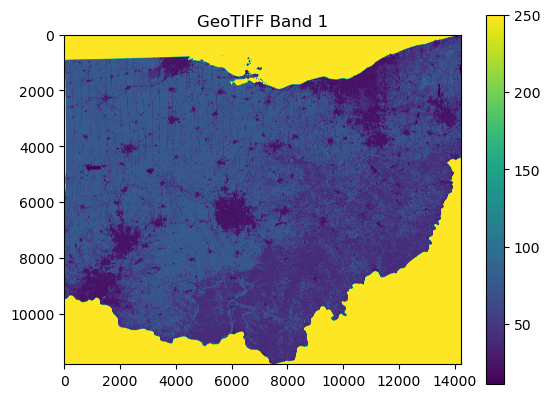

In [11]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open("./data2/land_coverage_oh.tif") as src:
    image = src.read(1)  # Read the first band

# Preview to ensure masking was successful
plt.imshow(image)
plt.colorbar()
plt.title("GeoTIFF Band 1")
plt.show()

In [13]:
# Get Ohio land coverage .tif file
raster_path = "./data2/land_coverage_oh.tif"

# Get geometry data for each congressional district
urbanization_cd_gdf = gdf_cd_proj.copy()
# cd_geom.head(20)

# Make sure they have the same projection
with rasterio.open("./data2/land_coverage_oh.tif") as src:
    print(src.crs)
    print(urbanization_cd_gdf.crs)

EPSG:4326
EPSG:4326


In [14]:
from rasterstats import zonal_stats

# Get pixel value counts per district
stats = zonal_stats(
    vectors=urbanization_cd_gdf,
    raster=raster_path,
    stats=None,  # no mean/sum, just raw counts
    categorical=True,
    nodata=0  # exclude nodata pixels (adjust if your nodata value is different)
)


In [15]:
# Add stats to the GeoDataFrame
urbanization_cd_gdf["dev_21"] = [s.get(21, 0) for s in stats]
urbanization_cd_gdf["dev_22"] = [s.get(22, 0) for s in stats]
urbanization_cd_gdf["dev_23"] = [s.get(23, 0) for s in stats]
urbanization_cd_gdf["dev_24"] = [s.get(24, 0) for s in stats]

# Add total developed area (pixel count)
urbanization_cd_gdf["dev_total"] = urbanization_cd_gdf[["dev_21", "dev_22", "dev_23", "dev_24"]].sum(axis=1)

# Total land pixels per district
urbanization_cd_gdf["total_pixels"] = [sum(s.values()) for s in stats]

# Calculate % developed for a measure of urbanization
urbanization_cd_gdf["urbanization_pct"] = (urbanization_cd_gdf["dev_total"] / urbanization_cd_gdf["total_pixels"]) * 100

urbanization_cd_gdf.head(20)


,CD119FP,GEOID,geometry,dev_21,dev_22,dev_23,dev_24,dev_total,total_pixels,urbanization_pct
34,06,3906,"POLYGON ((-81.84486 39.45022, -81.82576 39.449...",1140314,623994,241390,63261,2068959,14494849,14.273753
137,13,3913,"POLYGON ((-81.68780 41.02566, -81.68762 41.062...",437518,430150,220654,65434,1153756,1909902,60.409173
138,02,3902,"POLYGON ((-84.31524 39.05734, -84.31481 39.061...",1362654,628084,190596,45225,2226559,21915966,10.159529
200,09,3909,"MULTIPOLYGON (((-82.73280 41.60432, -82.72107 ...",353513,823644,342495,107865,1627517,8190249,19.871398
212,15,3915,"POLYGON ((-84.43257 40.19704, -84.43396 40.270...",314717,466015,281203,89624,1151559,5792584,19.879884
222,11,3911,"POLYGON ((-81.85595 41.41903, -81.85222 41.418...",113403,153500,223250,96670,586823,661692,88.685219
253,08,3908,"POLYGON ((-84.82016 39.22722, -84.81981 39.244...",430933,504424,218947,62663,1216967,5360440,22.702745
273,03,3903,"POLYGON ((-83.10299 40.06130, -83.09337 40.062...",104481,205208,196758,58010,564457,657675,85.826130
283,14,3914,"POLYGON ((-81.48892 41.62675, -81.48864 41.631...",843725,551592,219680,59329,1674326,7575258,22.102561
372,01,3901,"POLYGON ((-84.70727 39.13250, -84.70677 39.132...",304601,293191,177460,62419,837671,1805746,46.389193


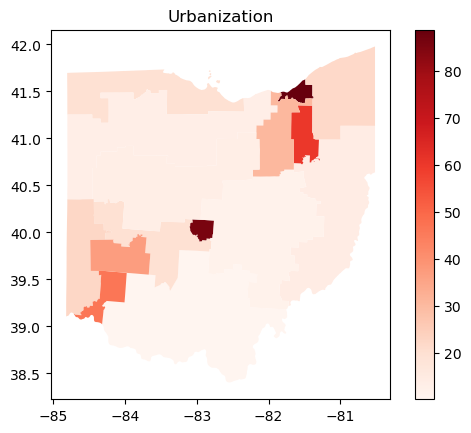

,CD119FP,GEOID,geometry,dev_21,dev_22,dev_23,dev_24,dev_total,total_pixels,urbanization_pct
34,06,3906,"POLYGON ((-81.84486 39.45022, -81.82576 39.449...",1140314,623994,241390,63261,2068959,14494849,14.273753
137,13,3913,"POLYGON ((-81.68780 41.02566, -81.68762 41.062...",437518,430150,220654,65434,1153756,1909902,60.409173
138,02,3902,"POLYGON ((-84.31524 39.05734, -84.31481 39.061...",1362654,628084,190596,45225,2226559,21915966,10.159529
200,09,3909,"MULTIPOLYGON (((-82.73280 41.60432, -82.72107 ...",353513,823644,342495,107865,1627517,8190249,19.871398
212,15,3915,"POLYGON ((-84.43257 40.19704, -84.43396 40.270...",314717,466015,281203,89624,1151559,5792584,19.879884


In [17]:
# Map
urbanization_cd_gdf.plot(column='urbanization_pct', cmap='Reds', legend=True)
plt.title("Urbanization")
plt.show()

urbanization_cd_gdf.head()

In [25]:
urbanization_2023 = urbanization_cd_gdf[['CD119FP', 'urbanization_pct']].copy()
urbanization_2023['CD119FP'] = urbanization_2023['CD119FP'].astype(int)

#urbanization_2023.head(20)

urbanization_2023.to_csv('./data2/urbanization_2023.csv', index=False)